In [4]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.offsetbox import AnchoredText

# Assumption about the velocity/ density field
\begin{align}
E_v(k) &= < \mathbf{v}(k) \mathbf{v}(k)*> & \propto k^{-\beta}\\
E_{\rho}(k) &= < \rho(k) \rho(k)*> & \propto k^{-\gamma}
\end{align}

The amplitudes of the velocity field (in $\vec{k}$ space) is generated from gaussian field with mean 0 and standard deviations of the power it has according to the prescribed $\beta$.
\begin{align}
<v_{|k|}v_{|k|}^*> &\propto k^{-\beta} \\
v_\vec{k}v_\vec{k}^* d^3 \vec{k}  &\propto |k|^{-\beta} \\
v_\vec{k}v_\vec{k}^* k^2 dk  &\propto |k|^{-\beta} \\
v_\vec{k} &\propto |k|^{\frac{-\beta -2}{2}}
\end{align}

Note that in this data here, we only need to consider the line-of-sight velocity. The velocity field generated with different $\beta$ are then normalized to the same standard deviations (linewidth) for a fair comparison.


The density field is generated similarly as for the velocity field, except that we are considering the lognormal field. In molecular clouds, supersonic turbulence and the compressible nature of isothermal gas in moelcular clouds give rises to a lognormal density distribution (Vazquez-Semadeni 1994; Burkhart et al. 2016 (transition from lognormal to power law pdf); although some claims that it need not imply supersonic turbulence (Tassis et al. 2010)).

The one point statistics/ probability distribution function is given by
\begin{align}
p(s) &= \frac{1}{\sqrt{2\pi\sigma_s^2}} exp( - \frac{- (s-s_0)^2}{2\sigma^2}) \\
s = ln(\rho/ \rho_0)
\end{align}
The correlation function (which is the fourier transform of the power spectrum) of the density field is then described by:
\begin{align}
C_{\rho}(x,y) &= < \rho(x) \rho(y)> \\
&= <e^{s(x)} e^{s(y)}> \\
&= e^{\frac{1}{2}S(x,x)+\frac{1}{2}S(y,y)+S(x,y)}
\end{align}
where $s$ is the gaussian normal field. Assuming isotropy and homogenity,
\begin{align}
C_{\rho}(0,x) &= e^{S(0,0)+S(0,x)} \\
E_{\rho}(k) = FT(C_{\rho}(0,x)) &= FT(e^{S(0,x)}) \\
&\approx FT( 1 + S(0,x) + \frac{1}{2!}S(0,x)^2 + ... )
\end{align}

If the Fourier transform of the S(0,x) decays fast enough, we can approximate $E_{\rho}(k)$ stil with a power law like spectrum, as we will show experimentally below 

In [2]:
# the range of beta and gamma
beta_range  = numpy.linspace(1.1 , 4.0, 100)
gamma_range = numpy.linspace(1.1 , 4.0, 100)

In [45]:
!rm sample_Pv.h5

In [46]:
f = h5py.File("sample_Pv.h5",'w')
f.create_dataset( "beta", data = sample_beta)
f.create_dataset( "Pv", data = power_spectrum )
f.create_dataset( "vbin", data = bins )
f.create_dataset("vhist", data = velocity_hist)
f.close()

In [47]:
f = h5py.File("sample_Pv.h5",'r')
print(list(f.keys()))
f.close()


['Pv', 'beta', 'vbin', 'vhist']


# Plotting sample velocity field

In [49]:
from generate_3dIC import calculate_power_spectrum

if os.path.exists("sample_Pv.h5"):
    print("power spectrum are calculated, reading from file")
    f = h5py.File("sample_Pv.h5",'r')
    
    sample_beta = f["beta"].value
    power_spectrum = f["Pv"].value
    bins = f["vbin"].value
    velocity_hist = f["vhist"].value
    
    f.close()
else:
    sample_beta = beta_range[::20]
    power_spectrum = []
    velocity_hist  = []
    NBINS = 100
    bins = np.linspace(-4,4, NBINS+1)

    for b in sample_beta:
        filename = "vdata/beta={0:.2f}.h5".format(b)
        f = h5py.File(filename)
        v = f['velocity']
        k, Pv   = calculate_power_spectrum(v, Rkbins = 128)
        hist, _ = np.histogram( v.value.flatten(), bins = bins)
        power_spectrum.append(Pv)
        velocity_hist.append(hist)

        f.close()
        print(filename)
    f = h5py.File("sample_Pv.h5",'w')
    f.create_dataset( "beta", data = sample_beta)
    f.create_dataset( "Pv", data = power_spectrum )
    f.create_dataset( "vbin", data = bins )
    f.create_dataset("vhist", data = velocity_hist)
    f.close()

power spectrum are calculated, reading from file


<function matplotlib.pyplot.show(*args, **kw)>

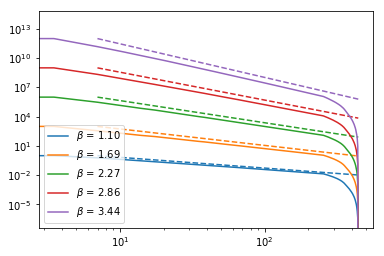

In [50]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i, b in enumerate(sample_beta):
    offset = 1000**i
    plt.loglog(k, power_spectrum[i] / power_spectrum[i][1] * offset,
               label=r"$\beta$ = {0:.2f}".format(b), 
               color= colors[i])
    plt.plot( k[2:], k[2:]**-b /k[2]**-b * offset, color= colors[i], ls ='--')
plt.legend()
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

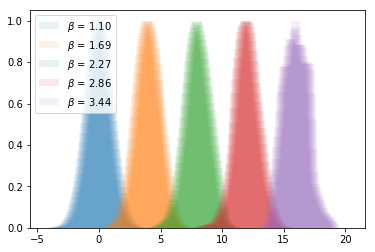

In [51]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i, b in enumerate(sample_beta):
    offset = 4.0
    vbin = 0.5*(bins[1:] +bins[:-1] )
    plt.bar(vbin + offset*i, velocity_hist[i]/velocity_hist[i].max(), color=colors[i], 
            label=r"$\beta$ = {0:.2f}".format(b),
            alpha = 0.1)
#     plt.plot( k[2:], k[2:]**-b /k[2]**-b * offset, color= colors[i], ls ='--')
plt.legend()
plt.show

# Plotting sample density field

In [83]:
if os.path.exists("sample_Prho.h5"):
    print("power spectrum are calculated, reading from file")
    f = h5py.File("sample_Prho.h5",'r')
    
    sample_gamma = f["gamma"].value
    power_spectrum = f["Prho"].value
    bins = f["rhobin"].value
    density_hist = f["rhohist"].value
    
    f.close()
else:

    sample_gamma = gamma_range[::20]
    power_spectrum = []
    density_hist  = []
    NBINS = 100
    bins = np.logspace(-4,4, NBINS+1)

    for g in sample_gamma:
        filename = "logddata/gamma={0:.2f}.h5".format(g)
        f = h5py.File(filename)
        d = f['density']
        k, Pd   = calculate_power_spectrum(d, Rkbins = 128)
        hist, _ = np.histogram( d.value.flatten(), bins = bins)
        power_spectrum.append(Pd)
        density_hist.append(hist)

        f.close()
        print(filename)
        
    f = h5py.File("sample_Prho.h5",'w')    
    f.create_dataset("gamma", data=sample_gamma)
    f.create_dataset("Prho", data=power_spectrum)
    f.create_dataset("rhobin", data= bins)
    f.create_dataset("rhohist", data=density_hist)    
    f.close()

logddata/gamma=1.10.h5
logddata/gamma=1.69.h5
logddata/gamma=2.27.h5
logddata/gamma=2.86.h5
logddata/gamma=3.44.h5


<function matplotlib.pyplot.show(*args, **kw)>

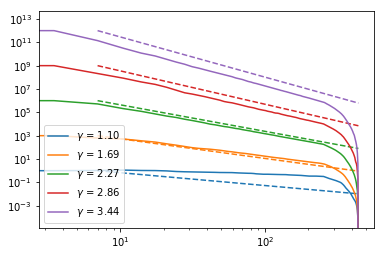

In [99]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i, g in enumerate(sample_gamma):
    offset = 1000**i
    plt.loglog(k, power_spectrum[i] / power_spectrum[i][1] * offset,
               label=r"$\gamma$ = {0:.2f}".format(g), 
               color= colors[i])
    plt.plot( k[2:], k[2:]**-g /k[2]**-g * offset, color= colors[i], ls ='--')
plt.legend()
plt.show

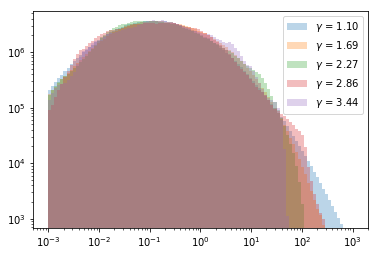

In [81]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for i, g in enumerate(sample_gamma):

    dbin = bins[:-1]
#     plt.bar(dbin, density_hist[i], color=colors[i], 
#             label=r"$\gamma$ = {0:.2f}".format(g),
#             alpha = 0.1)
    
    plt.bar(bins[:-1],density_hist[i], width=np.diff(bins), 
            align="edge", log=True, color=colors[i], 
            label=r"$\gamma$ = {0:.2f}".format(g),
            alpha = 0.3)
    
plt.xscale('log')
plt.legend()
plt.show()

# column density map as a function of $\gamma$

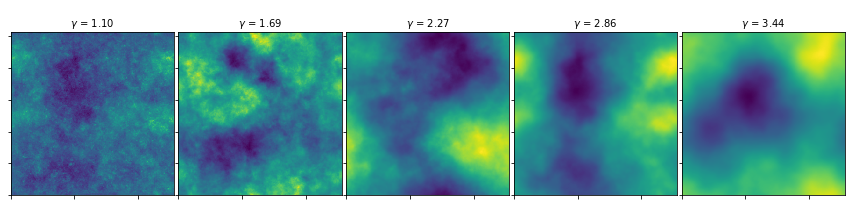

In [100]:
f, axarr = plt.subplots(1,5, figsize=(15,3), gridspec_kw = {'wspace':0.01, 'hspace':0})

 #f, axarr = plt.subplots(1,5 )

i = 0

data_colden = numpy.zeros((5, 512,512))

for j, g in enumerate(gamma_range[::20]):
    filename = "logddata/gamma={0:0.2f}.h5".format( g)
    if not os.path.isfile(filename):
        print(filename, ' not existed yet!')
    else:
        hf = h5py.File( filename ,'r')
        im = numpy.sum( hf['density'], axis = 2 )
        hf.close()
        im = numpy.array(im)
        im /= im.max()
        axim = axarr[j].pcolormesh( numpy.log10(im) )
        
        data_colden[j] = im
        
        axarr[j].set_xlabel("\n"+r"$\gamma$ = {0:.2f}".format(g) )
        axarr[j].xaxis.set_label_position('top')
        axarr[j].set_xticklabels([])
        axarr[j].set_yticklabels([])
        axarr[j].set_aspect("equal")



# creating PPV observations

PPV = Position-Position-Velocity Map
It is a 3d cubes where each line-of-sight is binned accordingly to the velocty and weighted by the density of the cell.

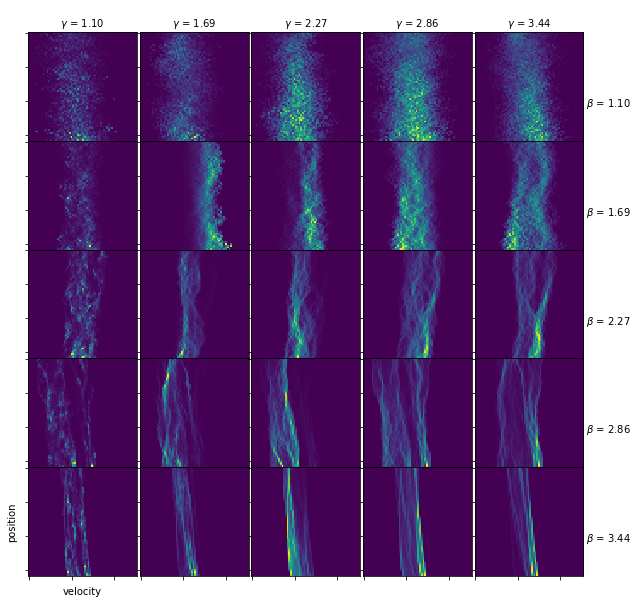

In [91]:
bskip = 0
NGAMMA = 5
NBETA = 5

center = [144,350]

gamma = numpy.zeros((NBETA,NGAMMA))
beta  = numpy.zeros((NBETA,NGAMMA))

data_ppv_slices = numpy.zeros((NBETA,NGAMMA, 64, 64))

f, axarr = plt.subplots(NBETA,NGAMMA, figsize=(10,10), gridspec_kw = {'wspace':0, 'hspace':0} )



for i, b in enumerate(beta_range[bskip:][::(100 - bskip) // NBETA]):
    if (i >= NBETA): break
    for j, g in enumerate(gamma_range[::20]):
        filename = "log_ppvdata/ppv_ln_d={0:0.4f}_v={1:0.4f}.h5".format( g, b )
        
        if (j >= NGAMMA ): break
        
        if not os.path.isfile(filename):
            print(filename, ' not existed yet!')
        else:
            hf = h5py.File( filename ,'r')
            im = hf['ppv'][ center[0], center[1] - 32: center[1]+ 32, : ]
            hf.close()
            im = numpy.array(im)
            axim = axarr[i,j].imshow(im/ max(im.flatten()) , vmin = 0.0, vmax = 1.0 )
            axarr[i,j].set_xticklabels([])
            axarr[i,j].set_yticklabels([])
            
            gamma[i,j] = g
            beta[i,j]  = b
            data_ppv_slices[i,j,:,:] = im/ max(im.flatten())
            
            if ( i == 4 and j == 0):
                axarr[i,j].set_xlabel("velocity")
                axarr[i,j].set_ylabel("position")
            else:
                axarr[i,j].set_xticklabels([])
                axarr[i,j].set_yticklabels([])

            if ( i == 0):
                axarr[i,j].set_xlabel("\n"+r"$\gamma$ = {0:.2f}".format(g) )
                axarr[i,j].xaxis.set_label_position('top')
                axarr[i,j].set_xticklabels([])
                axarr[i,j].set_yticklabels([])
            if ( j == 4):
                axarr[i,j].set_ylabel("\n"+r"$\beta$ = {0:.2f}".format(b), rotation = 360, labelpad=25 )
                axarr[i,j].yaxis.set_label_position('right')
                axarr[i,j].set_xticklabels([])
                axarr[i,j].set_yticklabels([])            
# f.savefig('sample_ppv.png')

# sample spectral line along a particular line of sight

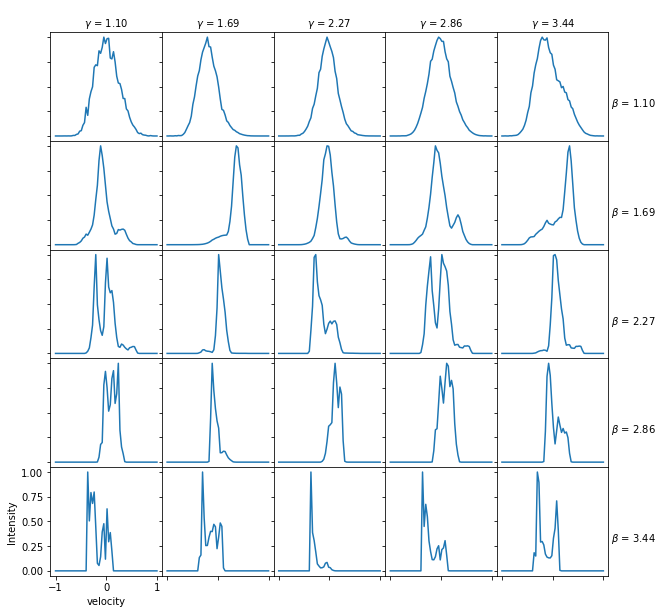

In [97]:
f, axarr = plt.subplots(5,5, figsize=(10,10), gridspec_kw = {'wspace':0, 'hspace':0} )

vax = numpy.linspace(-1,1,64)

data_ppv_1d = numpy.zeros((5,5, 64))

pos = [ [256,256] ]

for i, b in enumerate(beta_range[bskip:][::(100 - bskip) // 5]):
    for j, g in enumerate(gamma_range[::20]):
        filename = "log_ppvdata/ppv_ln_d={0:0.4f}_v={1:0.4f}.h5".format( g, b )
        if not os.path.isfile(filename):
            print(filename, ' not existed yet!')
        else:

            hf = h5py.File( filename ,'r')
            for x, y in pos:
                im = numpy.sum( numpy.sum( hf['ppv'][ x-5: x+5, y-5:y+5, : ], axis =0 ), axis=0)
                im = numpy.array(im)
                axim = axarr[i,j].plot( vax, im/ max(im.flatten()))
            hf.close()

            data_ppv_1d[i,j,:] = im/ max(im.flatten())
            
        if ( i == 4 and j == 0):
            axarr[i,j].set_xlabel("velocity")
            axarr[i,j].set_ylabel("Intensity")
        else:
            axarr[i,j].set_xticklabels([])
            axarr[i,j].set_yticklabels([])

        if ( i == 0):
            axarr[i,j].set_xlabel("\n"+r"$\gamma$ = {0:.2f}".format(g) )
            axarr[i,j].xaxis.set_label_position('top')
            axarr[i,j].set_xticklabels([])
        if ( j == 4):
            axarr[i,j].set_ylabel("\n"+r"$\beta$ = {0:.2f}".format(b), rotation = 360, labelpad= 25 )
            axarr[i,j].yaxis.set_label_position('right')
            axarr[i,j].set_xticklabels([])
            axarr[i,j].set_yticklabels([])
